Ce notebook va être consacré au preprocessing du dataset et l'entrainement d'un premier modèle simple pour établir une baseline.

---

# Load

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

random_state = 42

base_path = 'data'
file_name = 'season.csv'
years = range(2019, 2023)

In [2]:
from f1pitpred.loading import load_from_csv

data = load_from_csv(years, base_path, file_name)

# Preprocessing

In [3]:
from f1pitpred.preprocessing import get_preprocessed_train_test_split
df = data.copy()
train_df, test_df, encoder, train_groups, test_groups = get_preprocessed_train_test_split(
    df, 
    0.2, 
    return_groups=True, 
    random_state=random_state,
    target='tire'
)

from f1pitpred.preprocessing import get_x_y_tires
X_train, y_train = get_x_y_tires(train_df)
X_test, y_test = get_x_y_tires(test_df)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1530, 47) (384, 47) (1530, 3) (384, 3)


# Modelisation

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

def balanced_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    return (specificity + sensitivity) / 2

In [5]:
model = RandomForestClassifier(
    n_estimators=2000,
    max_depth=5, 
    max_features='sqrt',
    criterion='entropy',
    class_weight='balanced_subsample',
    random_state=random_state,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=5, n_estimators=2000, n_jobs=-1,
                       random_state=42)

In [6]:
y_pred = model.predict(X_test)

from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred, average='weighted'))

0.5990719829634523


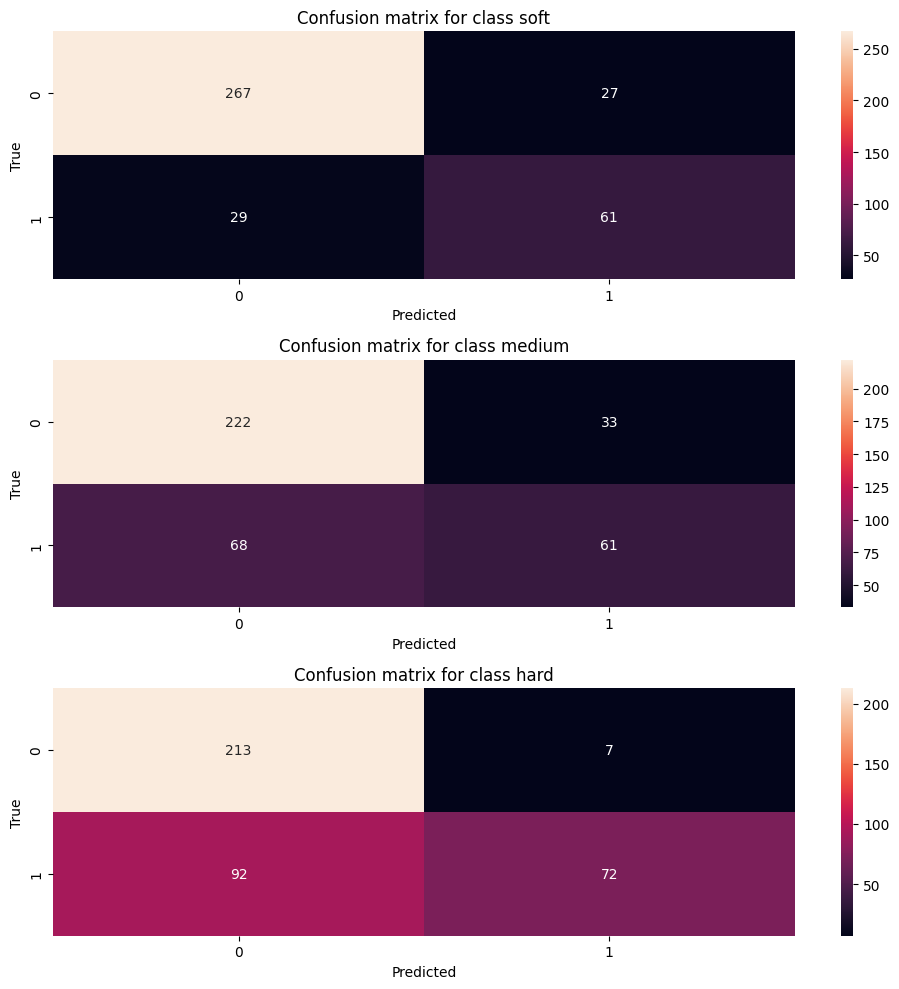

In [7]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

def plot_multilabel_confusion_matrix(y_true, y_pred, classes):
    n_classes = len(classes)
    fig, axes = plt.subplots(nrows=n_classes, ncols=1, figsize=(10, 10))
    for i, ax in enumerate(axes):
        cm = multilabel_confusion_matrix(y_true, y_pred)[i]
        sns.heatmap(cm, annot=True, ax=ax, fmt='g')
        ax.set_title(f'Confusion matrix for class {classes[i]}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    plt.tight_layout()
    plt.show()

plot_multilabel_confusion_matrix(y_test, y_pred, ['soft', 'medium', 'hard'])

In [8]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
print(multilabel_confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[[267  27]
  [ 29  61]]

 [[222  33]
  [ 68  61]]

 [[213   7]
  [ 92  72]]]
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        90
           1       0.65      0.47      0.55       129
           2       0.91      0.44      0.59       164

   micro avg       0.74      0.51      0.60       383
   macro avg       0.75      0.53      0.61       383
weighted avg       0.77      0.51      0.60       383
 samples avg       0.51      0.51      0.51       383



c:\Users\nelso\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nelso\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
validation_data = load_from_csv([2023], base_path, "spanish_grand_prix.csv")

validation_data = validation_data[validation_data['DriverNumber'] == '1']
from f1pitpred.preprocessing import preprocess_new_data
validation_df = preprocess_new_data(validation_data, encoder, target='tire')

In [45]:
x, y = get_x_y_tires(validation_df)

In [46]:
proba = model.predict_proba(x)

In [47]:
from f1pitpred.plotting import plot_remove_duplicate_legends

def plot_race_predictions(x, y, proba, ax, colors=['red', 'yellow', 'gray'], marker='X', labels=['Soft', 'Medium', 'Hard'], title='Predicted pitstops'):
    """
    Plot pitstop predictions for series of laps

    Parameters
    ----------
    x : pandas DataFrame
        A dataframe containing the following columns:
        - LapNumber
        - TotalLaps
    y : array-like
        The ground truth pitstop labels
    proba : array-like
        The predicted probability of pitting
    ax : matplotlib Axes
        The axes to plot on
    color : str, default 'cyan'
        The color of the plotted points
    marker : str, default 'X'
        The marker of the plotted points
    label : str, default 'Predicted pitstop'
        The label of the plotted points
    title : str, default 'Predicted pitstops'
        The title of the plot

    Returns
    -------
    ax : matplotlib Axes
        The axes with the plotted points
    """
    x['index'] = x['LapNumber']
    x = x.set_index('index')
    y.index = x.index

    ax.hlines(y=0.5, xmin=x['LapNumber'].min(), xmax=x['TotalLaps'].max(), linewidth=1, colors='black', linestyles='dotted', zorder=0)
    for i, tire_proba in enumerate(proba):
        sns.scatterplot(x=x['LapNumber'], y=tire_proba[:, 1], marker=marker, legend=False, ax=ax, s=50, label=labels[i], color=colors[i])
        sns.lineplot(x=x['LapNumber'], y=tire_proba[:, 1], linewidth=1, linestyle='dashed', zorder=0, ax=ax, color=colors[i])
    ax.set_xlabel('Lap Number')
    ax.set_xticks(np.arange(0, x['TotalLaps'].max(), 5))
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability of pitting')
    ax.set_xlim(x['LapNumber'].min(), x['TotalLaps'].max())    

    ax.set_title(title)
    return plot_remove_duplicate_legends(ax, loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0.)

<Axes: title={'center': 'Predicted pitstops'}, xlabel='Lap Number', ylabel='Probability of pitting'>

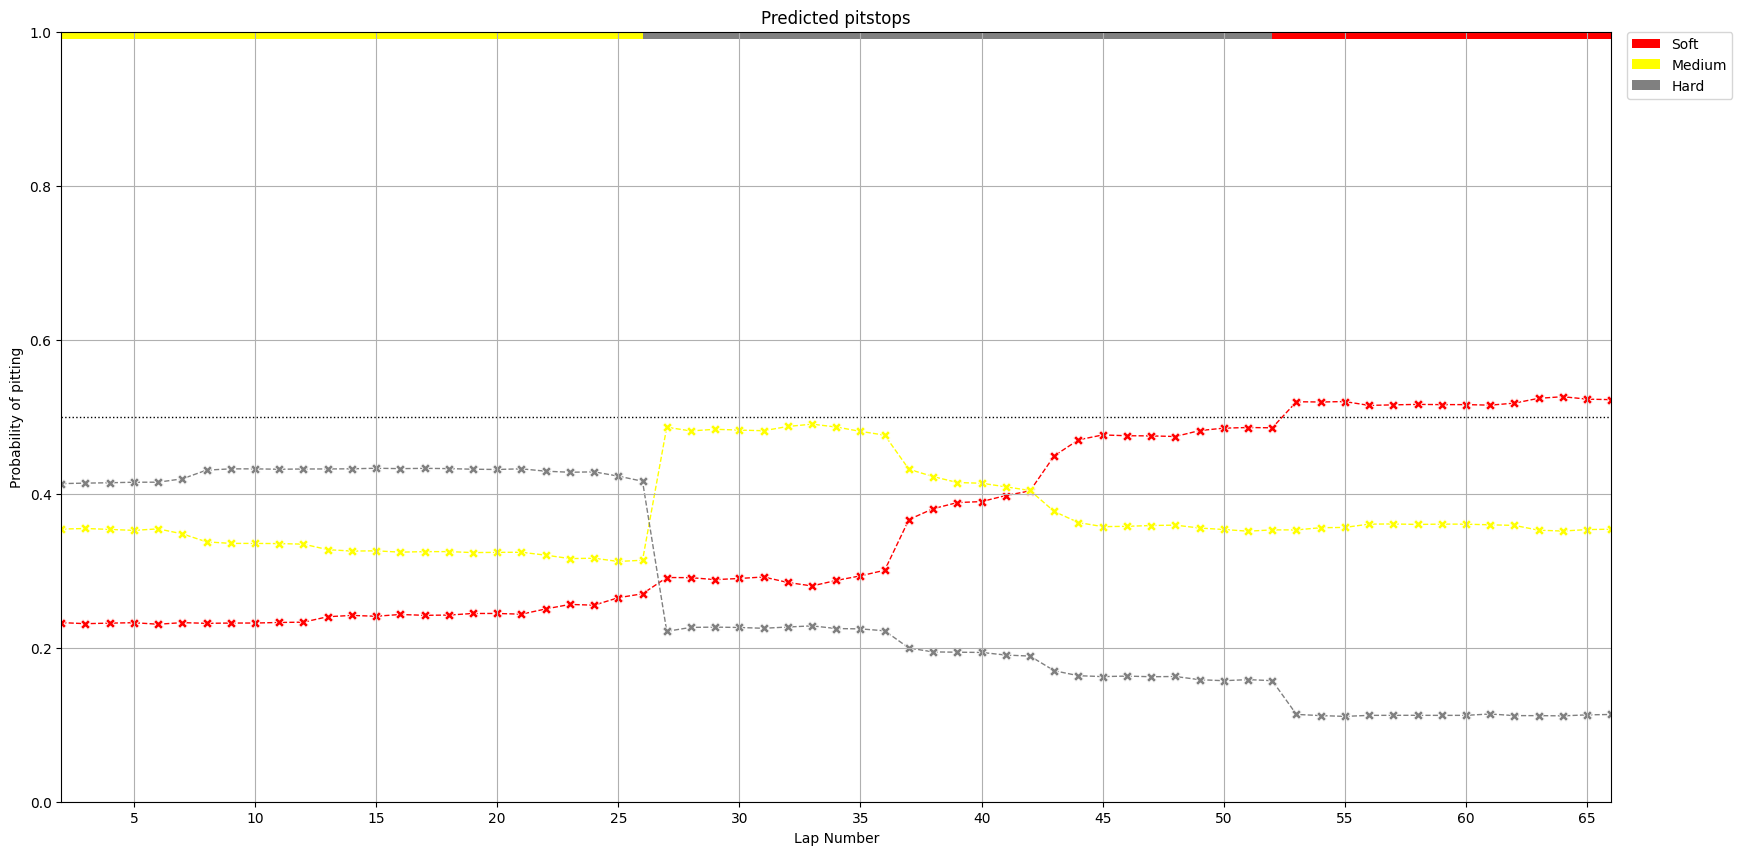

In [48]:
from f1pitpred.plotting import plot_stoppages, plot_tyres

fig, ax = plt.subplots(figsize=(20, 10))
ax.grid()
plot_race_predictions(x, y, proba, ax)
plot_stoppages(x, ax)
plot_tyres(x, ax)


In [49]:
# Save model
import pickle
models_dir = 'models/balanced_accuracy_2'
os.makedirs(models_dir, exist_ok=True)
pickle.dump(model, open(models_dir + '/model.pkl', 'wb'))
pickle.dump(encoder, open(models_dir + '/encoder.pkl', 'wb'))